In [13]:
import os
import json
import re
import glob
import numpy as np
from collections import defaultdict

In [14]:
def load_game_logs(folder):
    game_logs = []
    for p in sorted(glob.glob(os.path.join(folder, "game_log_*.json"))):
        with open(p, "r", encoding="utf-8") as f:
            game_logs.append(json.load(f))
    return game_logs


def load_player_logs(folder):
    player_logs = defaultdict(list)
    for p in glob.glob(os.path.join(folder, "player_log_*.jsonl")):
        player_id = int(os.path.basename(p).split("_")[2].split(".")[0])
        with open(p, "r", encoding="utf-8") as f:
            for line in f:
                player_logs[player_id].append(json.loads(line))
    return player_logs


In [3]:
# spy胜率
def compute_spy_win_rate(game_logs):
    return sum(1 for g in game_logs if g["metadata"]["winner"] == "spy") / len(game_logs)


In [4]:
# Spy 存活轮数 & 平均存活轮数
def compute_spy_survival_rounds(game_logs):
    survival = []
    for g in game_logs:
        spy = g["metadata"]["spy_id"]
        last_round = 1
        for item in g["public_log"]:
            if item.get("phase") == "vote_reveal":
                last_round = item["round_num"]
            if item.get("phase") == "vote_result":
                if f"Player {spy} receives" in item["content"]:
                    break
        survival.append(last_round)
    return survival


def compute_avg_spy_survival_round(game_logs):
    return float(np.mean(compute_spy_survival_rounds(game_logs)))

In [5]:
# SR @ K
def compute_SR_at_k(game_logs, k):
    alive_k = 0
    for g in game_logs:
        max_round = 0
        for item in g["public_log"]:
            max_round = max(max_round, item["round_num"])
        if max_round > k:
            alive_k += 1
    total = len(game_logs)
    return alive_k / total if total > 0 else 0.0

In [6]:
# Spy 每轮承受投票压力
def compute_spy_votes_per_round(game_logs):
    all_avg_votes = []

    for g in game_logs:
        spy = g["metadata"]["spy_id"]
        round_votes = {}

        for item in g["public_log"]:
            if item.get("phase") != "vote_reveal":
                continue

            r = item["round_num"]
            text = item["content"]
            tail = text.split("result is:")[-1].replace("\n", " ").strip()
            parts = tail.split(",")

            cnt = 0
            for seg in parts:
                m = re.search(r"Player\s+(\d+)\s+votes\s+for\s+Player\s+(\d+)", seg)
                if m and int(m.group(2)) == spy:
                    cnt += 1

            round_votes[r] = cnt

        avg_votes = np.mean(list(round_votes.values())) if round_votes else 0.0
        all_avg_votes.append(avg_votes)

    return all_avg_votes


In [7]:
# Civilians 误杀率（VSR）
def compute_civilian_elimination_ratio_by_round(game_logs):
    total_rounds = 0
    civilian_elimination = 0

    for g in game_logs:
        role_map = {p["player_id"]: p["role"] for p in g["metadata"]["players"]}

        for item in g["public_log"]:
            if item["phase"] == "vote_reveal":
                total_rounds += 1

            if item["phase"] == "vote_result":
                text = item["content"]
                m = re.search(r"Player (\d+) receives \d+ votes and is eliminated", text)
                if m:
                    eliminated = int(m.group(1))
                    if role_map.get(eliminated) != "spy":
                        civilian_elimination += 1
                elif "tie" in text.lower() or "No elimination" in text:
                    civilian_elimination += 1

    return civilian_elimination / total_rounds if total_rounds > 0 else 0.0


In [ ]:
def iter_spy_self_guess_events(game_logs, player_logs):
    """
    遍历所有游戏中 spy 的 self_identity_guess 事件。
    返回 (game_id, spy_id, round_num, guess_role) 四元组。
    """
    for g in game_logs:
        game_id = g["metadata"]["game_id"]
        spy_id = g["metadata"]["spy_id"]

        for rec in player_logs.get(spy_id, []):
            meta = rec.get("metadata", {})
            if meta.get("game_id") != game_id:
                continue

            for ev in rec.get("log_info", []):
                if ev.get("phase") == "self_identity_guess":
                    yield game_id, spy_id, ev.get("round_num"), ev.get("guess_role")

In [ ]:
# JCAP（Spy 自我识别率）
def compute_JCAP_for_spy(game_logs, player_logs):
    """
    JCAP（按“每局是否至少一次成功自我识别”定义）

    对每一局 game：
    - 只要该局中 spy 有一次 self_identity_guess == "spy"
      → 该局记为 1
    - 否则该局记为 0
    """

    correct_games = 0
    total_games = 0

    for g in game_logs:
        game_id = g["metadata"]["game_id"]
        spy_id = g["metadata"]["spy_id"]

        total_games += 1
        found_correct = False

        for rec in player_logs.get(spy_id, []):
            meta = rec.get("metadata", {})
            if meta.get("game_id") != game_id:
                continue

            for ev in rec.get("log_info", []):
                if ev.get("phase") == "self_identity_guess":
                    if ev.get("guess_role") == "spy":
                        correct_games += 1
                        found_correct = True
                        break

            if found_correct:
                break

    return correct_games / total_games if total_games > 0 else 0.0



In [25]:
# INF（Spy 认知更新能力）
def compute_INF_for_spy(game_logs, player_logs):
    total_updates = 0
    successful = 0

    for g in game_logs:
        spy_id = g["metadata"]["spy_id"]
        records = [
            r for r in player_logs[spy_id]
            if r.get("phase") == "self_identity_guess" and r.get("round_num") is not None
        ]

        records = sorted(records, key=lambda x: x["round_num"])

        for i in range(1, len(records)):
            prev = records[i - 1].get("guess_role")
            curr = records[i].get("guess_role")
            if prev is None or curr is None:
                continue
            total_updates += 1
            if prev != curr:
                successful += 1

    return successful / total_updates if total_updates > 0 else 0.0

In [39]:
def evaluate_all_metrics(game_logs, player_logs, K_list=[1,2,3,4,5,6]):
    result = {}

    result["spy_win_rate"] = compute_spy_win_rate(game_logs)
    result["avg_spy_survival_round"] = compute_avg_spy_survival_round(game_logs)

    for k in K_list:
        result[f"SR@{k}"] = compute_SR_at_k(game_logs, k)

    votes = compute_spy_votes_per_round(game_logs)
    result["avg_votes_against_spy_per_round"] = float(np.mean(votes))

    result["civilian_elimination_ratio"] = compute_civilian_elimination_ratio_by_round(game_logs)
    result["JCAP_spy"] = compute_JCAP_for_spy(game_logs, player_logs)
    # result["INF_spy"] = compute_INF_for_spy(game_logs, player_logs)

    return result


In [27]:
game_logs = load_game_logs("./results/civ_gpt_5mini_spy_qwen_cheatsheet_JCAP_medium_50")
player_logs = load_player_logs("./results/civ_gpt_5mini_spy_qwen_cheatsheet_JCAP_medium_50")

metrics = evaluate_all_metrics(game_logs, player_logs, K_list=[1,2,3,4,5,6])
metrics

{'spy_win_rate': 0.12244897959183673,
 'avg_spy_survival_round': 2.6530612244897958,
 'SR@1': 0.6326530612244898,
 'SR@2': 0.4489795918367347,
 'SR@3': 0.2653061224489796,
 'SR@4': 0.20408163265306123,
 'SR@5': 0.10204081632653061,
 'SR@6': 0.0,
 'avg_votes_against_spy_per_round': 2.13265306122449,
 'civilian_elimination_ratio': 0.6692307692307692,
 'JCAP_spy': 1.0,
 'INF_spy': 0.0}

In [ ]:
FOLDERS_50 = {
    # "JCAP_easy_50": "./results/civ_gpt_5mini_spy_qwen_cheatsheet_JCAP_easy_50",
    "+ Cheatsheet + Prompt Reg ": "./results/civ_gpt_5mini_spy_qwen_cheatsheet_JCAP_medium_50",
    # "JCAP_hard_50": "./results/civ_gpt_5mini_spy_qwen_cheatsheet_JCAP_hard_50",
    "+ Cheatsheet ": "./results/civ_gpt_5mini_spy_qwen_cheatsheet_medium_50",
    "+ Prompt Reg":"./results/civ_gpt_5mini_spy_qwen_JCAP_medium_50",
    "No Cheatsheet":"./results/civ_gpt_5mini_spy_qwen_medium_50",
    # "single_cheatsheet_medium_50":"./results/single_game_qwen_cheatsheet_medium_50",
    # "single_medium_50":"./results/single_game_qwen_medium_50"
}


In [64]:
def evaluate_multiple_folders(folder_dict, K_list=[1,2,3,4,5,6]):
    all_results = {}

    for name, folder in folder_dict.items():
        game_logs = load_game_logs(folder)
        player_logs = load_player_logs(folder)

        metrics = evaluate_all_metrics(game_logs, player_logs, K_list=K_list)
        all_results[name] = metrics

    return all_results


In [65]:
all_metrics_50 = evaluate_multiple_folders(FOLDERS_50)
all_metrics_50


{'+ Cheatsheet + Prompt Reg ': {'spy_win_rate': 0.12244897959183673,
  'avg_spy_survival_round': 2.6530612244897958,
  'SR@1': 0.6326530612244898,
  'SR@2': 0.4489795918367347,
  'SR@3': 0.2653061224489796,
  'SR@4': 0.20408163265306123,
  'SR@5': 0.10204081632653061,
  'SR@6': 0.0,
  'avg_votes_against_spy_per_round': 2.13265306122449,
  'civilian_elimination_ratio': 0.6692307692307692,
  'JCAP_spy': 1.0},
 '+ Cheatsheet ': {'spy_win_rate': 0.12,
  'avg_spy_survival_round': 2.06,
  'SR@1': 0.44,
  'SR@2': 0.3,
  'SR@3': 0.18,
  'SR@4': 0.1,
  'SR@5': 0.04,
  'SR@6': 0.0,
  'avg_votes_against_spy_per_round': 2.465,
  'civilian_elimination_ratio': 0.5728155339805825,
  'JCAP_spy': 0.0},
 '+ Prompt Reg': {'spy_win_rate': 0.14,
  'avg_spy_survival_round': 2.12,
  'SR@1': 0.6,
  'SR@2': 0.32,
  'SR@3': 0.12,
  'SR@4': 0.08,
  'SR@5': 0.0,
  'SR@6': 0.0,
  'avg_votes_against_spy_per_round': 2.1673333333333336,
  'civilian_elimination_ratio': 0.5943396226415094,
  'JCAP_spy': 1.0},
 'No Chea

In [66]:
import matplotlib.pyplot as plt

def plot_metric_bar(all_metrics, metric_key, title=None):
    names = list(all_metrics.keys())
    values = [all_metrics[n][metric_key] for n in names]

    plt.figure()
    plt.bar(names, values)
    plt.ylabel(metric_key)
    plt.title(title if title else metric_key)
    plt.xticks(rotation=30)
    plt.grid(True, axis="y")
    plt.show()


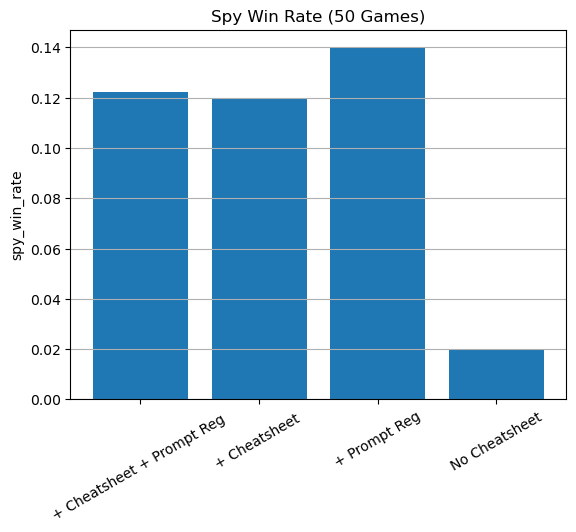

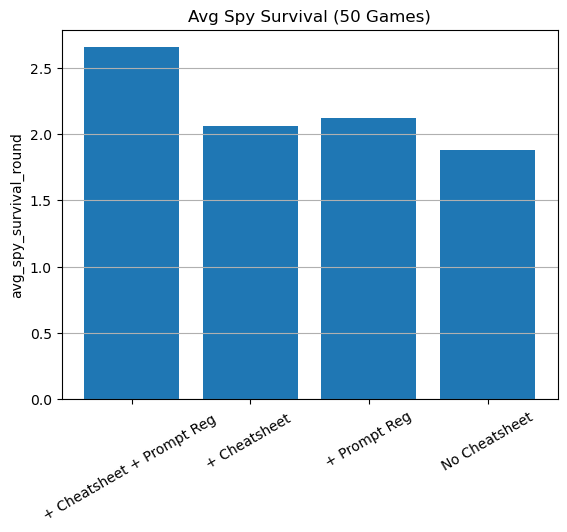

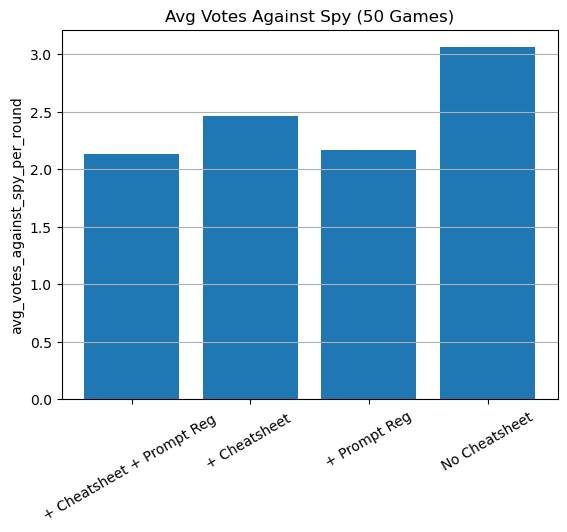

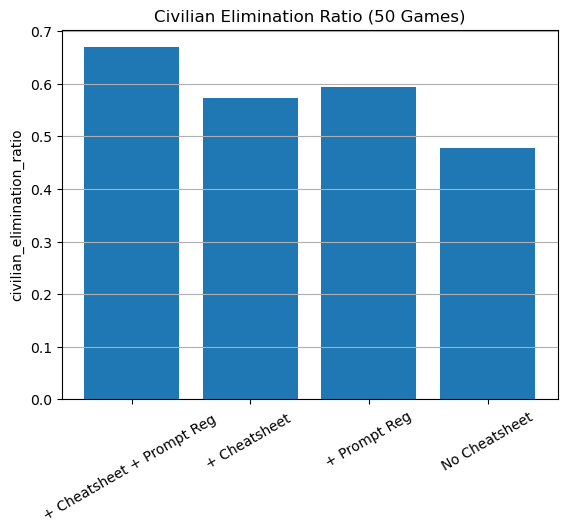

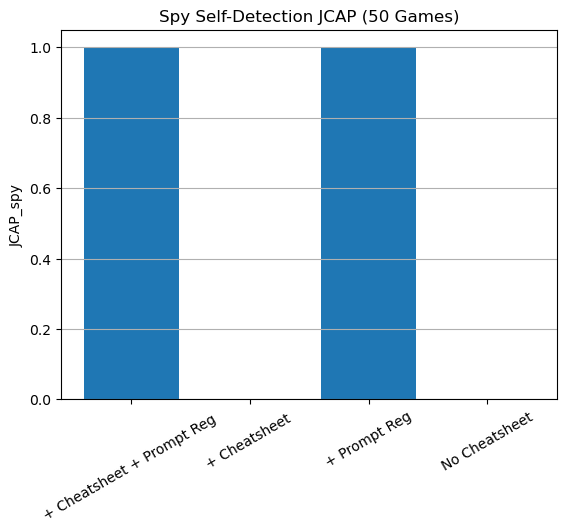

In [67]:
plot_metric_bar(all_metrics_50, "spy_win_rate", "Spy Win Rate (50 Games)")
plot_metric_bar(all_metrics_50, "avg_spy_survival_round", "Avg Spy Survival (50 Games)")
plot_metric_bar(all_metrics_50, "avg_votes_against_spy_per_round", "Avg Votes Against Spy (50 Games)")
plot_metric_bar(all_metrics_50, "civilian_elimination_ratio", "Civilian Elimination Ratio (50 Games)")
plot_metric_bar(all_metrics_50, "JCAP_spy", "Spy Self-Detection JCAP (50 Games)")
# plot_metric_bar(all_metrics_50, "INF_spy", "Spy INF (50 Games)")


In [75]:
def plot_SR_curves(all_metrics, max_k=6):
    plt.figure()

    for name, metrics in all_metrics.items():
        ks = list(range(1, max_k + 1))
        values = [metrics.get(f"SR@{k}", 0) for k in ks]
        plt.plot(ks, values, marker="o", label=name)

    plt.xlabel("Round k")
    plt.ylabel("SR@k")
    plt.title("Spy Survival Curves (SR@k) in Ablation Study",fontweight="bold") 
    plt.legend()
    plt.grid(True)
    plt.show()


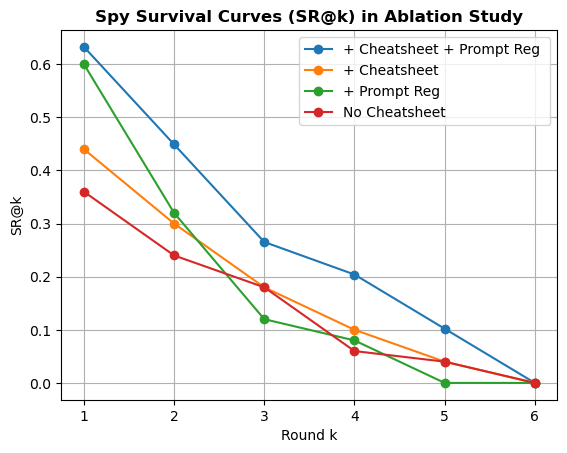

In [76]:
plot_SR_curves(all_metrics_50, max_k=6)